In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load your processed data
data = pd.read_csv('data/processed_data.csv')

# Ensure datetime is parsed correctly
data['datetime'] = pd.to_datetime(data['datetime'])

# Separate features and labels
X = data.drop(columns=['failure', 'datetime', 'machineID'])
y = data['failure']


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Choose the sequence length (e.g., last 10 time steps)
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps)


X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)




In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten for SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])  # Reshape back


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\Ark\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,441 (130.63 KB)

 Trainable params: 33,441 (130.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


Epoch 1/50
8762/8762 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.5500 - loss: 0.7234 - val_accuracy: 0.7760 - val_loss: 0.5812
Epoch 2/50
8762/8762 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.6446 - loss: 0.6639 - val_accuracy: 0.6727 - val_loss: 0.6266
Epoch 3/50
8762/8762 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.6700 - loss: 0.6481 - val_accuracy: 0.6104 - val_loss: 0.6941
Epoch 4/50
8762/8762 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.6249 - loss: 0.6277 - val_accuracy: 0.0171 - val_loss: 0.6991
Epoch 5/50
8762/8762 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.6011 - loss: 0.6865 - val_accuracy: 0.0071 - val_loss: 0.9233
Epoch 6/50
8762/8762 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.5193 - loss: 0.6779 - val_accuracy: 0.7160 - val_loss: 0.6381


In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Predict
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")



history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()



5476/5476 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.87    175075
         1.0       0.00      0.36      0.00       152

    accuracy                           0.78    175227
   macro avg       0.50      0.57      0.44    175227
weighted avg       1.00      0.78      0.87    175227

ROC AUC Score: 0.6545


KeyError: 'loss'

c:\Users\Shivansh\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43769/43769 ━━━━━━━━━━━━━━━━━━━━ 92s 2ms/step - accuracy: 0.4992 - loss: 6.6409 - val_accuracy: 8.2749e-04 - val_loss: 6.8806 - learning_rate: 1.0000e-04
Epoch 2/50
43769/43769 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.4995 - loss: 1.9635 - val_accuracy: 8.2749e-04 - val_loss: 6.6465 - learning_rate: 1.0000e-04
Epoch 3/50
43769/43769 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.4990 - loss: 1.9546 - val_accuracy: 8.2749e-04 - val_loss: 6.6957 - learning_rate: 1.0000e-04
Epoch 4/50
43769/43769 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.4999 - loss: 1.9517 - val_accuracy: 8.2749e-04 - val_loss: 6.7389 - learning_rate: 1.0000e-04
Epoch 5/50
43769/43769 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.5002 - loss: 1.9429 - val_accuracy: 8.2749e-04 - val_loss: 6.6843 - learning_rate: 1.0000e-04
Epoch 6/50
43769/43769 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.5006 - loss: 1.9273 - val_accuracy: 8.2749e-04 - val_loss: 6.8479 - learning_rate: 5.0000e-05
Epoch 7/50

c:\Users\Shivansh\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shivansh\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shivansh\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

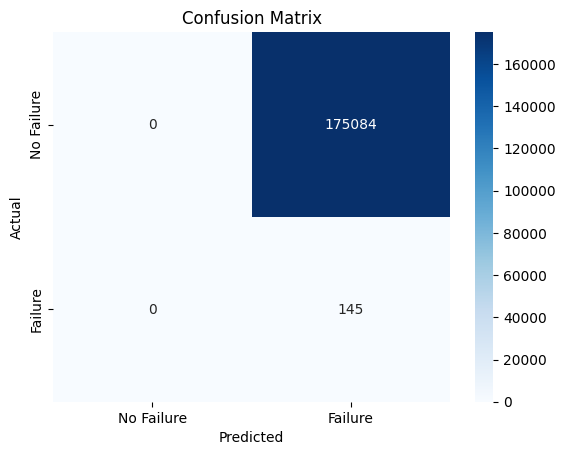

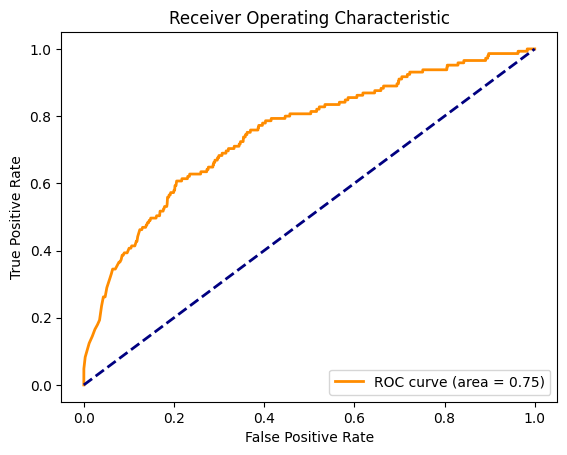

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
data = pd.read_csv('data/processed_data.csv')

# Define features and target
X = data.drop(columns=['failure', 'datetime', 'machineID']).values
y = data['failure'].values

# Reshape features for LSTM input
X = X.reshape(X.shape[0], 1, X.shape[1])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten for SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])  # Reshape back

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


c:\Users\Shivansh\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - accuracy: 0.9988 - loss: 0.1941 - val_accuracy: 0.9991 - val_loss: 0.0222 - learning_rate: 0.0010
Epoch 2/50
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - accuracy: 0.9991 - loss: 0.1843 - val_accuracy: 0.9991 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 3/50
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - accuracy: 0.9992 - loss: 0.1776 - val_accuracy: 0.9991 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 4/50
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - accuracy: 0.9990 - loss: 0.1998 - val_accuracy: 0.9991 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 5/50
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - accuracy: 0.9991 - loss: 0.1893 - val_accuracy: 0.9991 - val_loss: 0.0667 - learning_rate: 5.0000e-04
Epoch 6/50
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - accuracy: 0.9991 - loss: 0.1822 - val_accuracy: 0.9991 - val_loss: 0.0347 - learning_rate: 5.0000e-04
5476/5476 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


c:\Users\Shivansh\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shivansh\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shivansh\OneDrive\Desktop\git_repos\Predictive_maintenance_telemetry\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

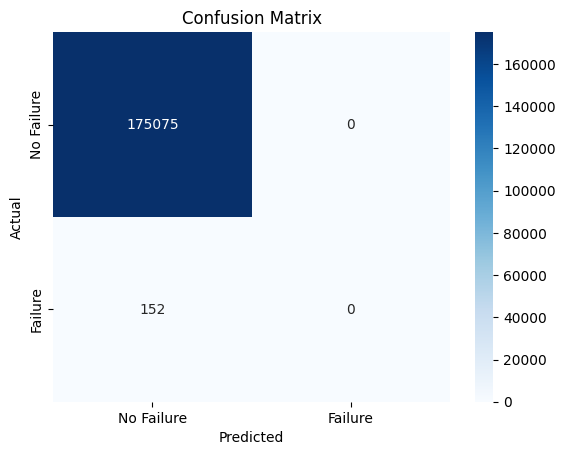

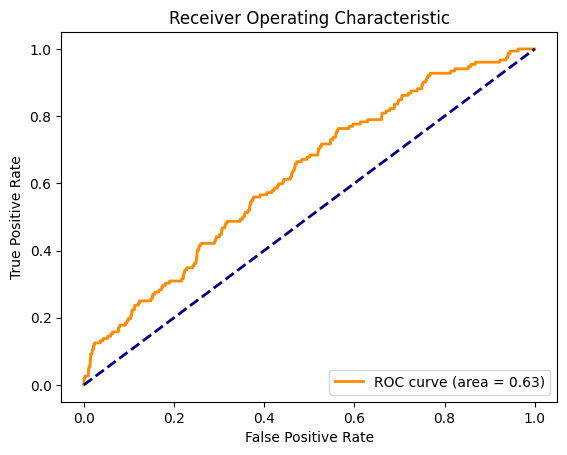

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
data = pd.read_csv('data/processed_data.csv')

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(data.drop(columns=['failure', 'datetime', 'machineID']))
y = data['failure'].values

# Reshape data into sequences for LSTM
sequence_length = 10
X_sequences, y_sequences = [], []
for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i+sequence_length])
    y_sequences.append(y[i+sequence_length-1])
X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences)

# Define LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight={0: 1.0, 1: 50.0},  # Adjust class weights as needed
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
